In [1]:
import numpy as np
from coupled_phaser import cpr
import Phaser as ph
import forward_model as fm
from miscellaneous import rescale_noise,plot_u,center_u,unpack_obj
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tensorflow as tf
from copy import copy

## How to Forward Model a dataset ##

This is a simple forward model which isn't that realistic, as we just use discrete fourier transform. It is fine for what we are doing here.

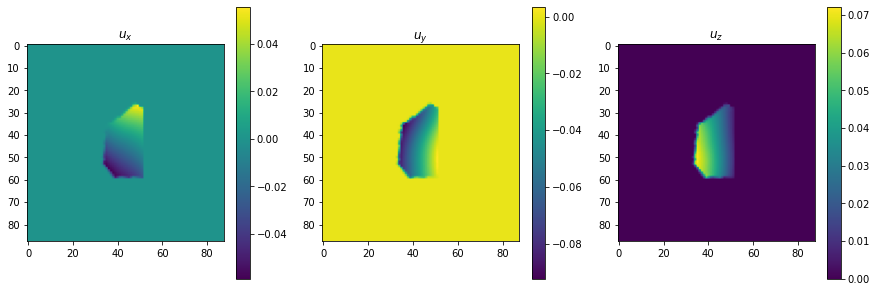

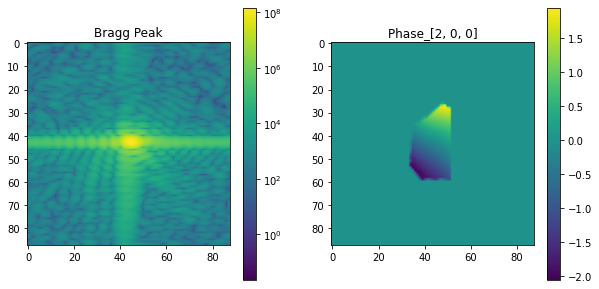

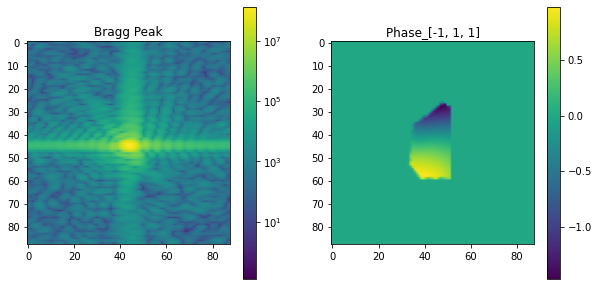

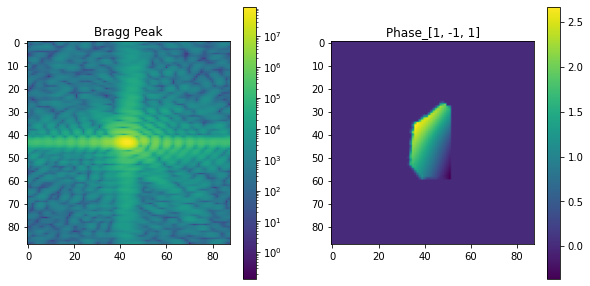

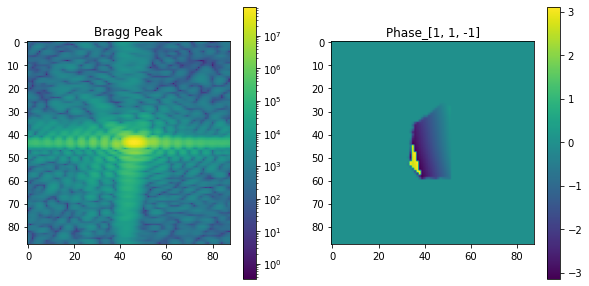

1
1000058
1


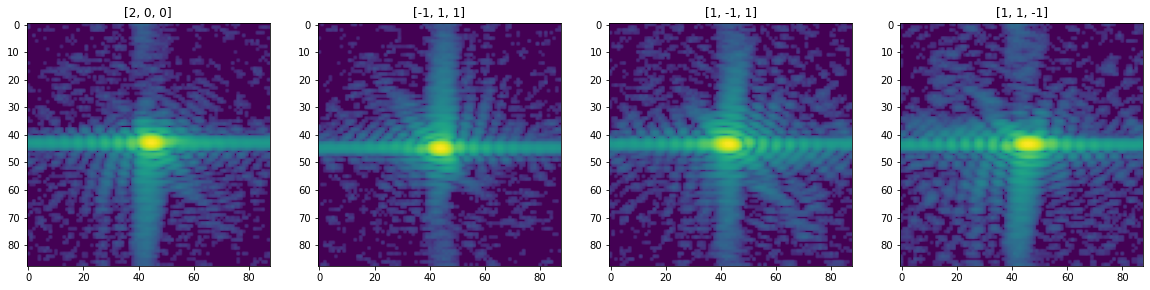

In [2]:
#define the reflections you want to model
qs = [[2,0,0],[-1,1,1],[1,-1,1],[1,1,-1]]

# define a displacement field
u = np.load('parent_u.npy')[:,20:-20,20:-20,20:-20]
# define a support function
sup = np.load('parent_sup2.npy')[20:-20,20:-20,20:-20]
#define lattice constant
a = 0.3597


data = []            
fmodel = fm.f_model(sup,u,a,plot=True)
for q in qs:
    data.append(fmodel.forward(q,plot=True)[0])
dat_0 = copy(data[1])

data = np.stack(rescale_noise(data,1e6))
print(np.sort(np.unique(data[0]))[1])
print(np.max(data[0]))

data[data<5.] = 1
print(data.min())
fig,ax = plt.subplots(ncols = len(data),figsize = (5*len(data),8))
for i,d in enumerate(data):
    ax[i].imshow(d[:,:,d.shape[2]//2],norm=LogNorm())
    ax[i].set_title(qs[i])
plt.show()



In [3]:
# #formula for estimating chi
# chi_square = lambda model,data,mask : np.mean(((model - data)**2/data)[mask])

# use_mod = []
# use_intens = []
# powers = np.arange(5.,10.,0.25)
# for power in powers:

#     fac = 1*10**(power)
    
#     #Intensity with no noise, mimicking the model
#     F = data[0]/data[0].max()*fac
    
  
#     #Intensity with poisson noise, mimicking measured data
#     I = rescale_noise([F],fac)[0]
    
# #     print(I[I>0].min(),I.max())
#     F[F<1] = 0
#     I[I<1] = 0
#     mask = I>1
#     plt.imshow(I[:,:,I.shape[2]//2],norm=LogNorm())
#     plt.show()

    
#     use_intens.append(chi_square(F,I,mask))
#     use_mod.append(chi_square(np.sqrt(F),np.sqrt(I),mask))
    
# print(use_intens)
# plt.figure(figsize=(7,6))
# plt.plot(powers,use_intens,label=r'$\frac{(I-f^2)^2}{I}$')
# plt.plot(powers,use_mod,label=r'$\frac{(\sqrt{I}-f)^2}{\sqrt{I}}$')
# plt.ylabel(r'$\hat{\chi}^2$')
# plt.xlabel('log(photon_max)')
# plt.legend(prop={'size': 16})
# plt.show()

## Recipe Instructions ##

There are three options: ER,HIO,SF

recipes is a list of lists, containing two elements each:

First: the phasing method (ER,HI0,SF) followed by the number of iterations
Second: Shrinkwrap option (applied to universal amplitude), a list of two values [sigma,threshold], if no shrinkwrap is wanted, make this element [0]

Every sublist is applied to all constituents and then the constituents are combined to compute the updated guess for $\textbf{u}$ and $\rho$.

#### Example: ####
30 iterations of ER followed by shrinkwrap with sigma 1.0, threshold 0.1 on $\rho$, then 50 iterations of HIO with no shrinkwrap

$[[\text{'ER:30'},[1.0,0.1]],[\text{'HIO'},[0]]]$

In [4]:


r1 = 'ER:30'
num_it = 20
recipes = [[r1,[0]] for i in range(num_it)]
for i in range(1,21,3):
    recipes[i] = ['HIO:30',[0]]
for i in range(0,20,3):
    recipes[i] = [r1,[1.0,0.1]]
recipes[-1] = [r1,[1.0,0.1]]

print(recipes)

[['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['HIO:30', [0]], ['ER:30', [0]], ['ER:30', [1.0, 0.1]], ['ER:30', [1.0, 0.1]]]


## Free $\chi^2$ ##

Using the logic from https://www.nature.com/articles/s41598-020-57561-2 to measure overfitting, you can choose to mask the modulus so that the fourier space constraint is not applied to a set of free voxels. $\chi^2$ is then a measure of the validation error on the masked voxels. The mask is given as input __free_vox_mask__. An example can be seen below:

In [5]:
shp = data[0].shape
mask = np.zeros_like(data[0])
num_seeds = np.size(mask)/(20*27)
seeds = np.random.randint(3,shp[0]-3,size = (np.int32(num_seeds),3))

for seed in seeds:
    mask[seed[0]-1:seed[0]+1,seed[1]-1:seed[1]+1,seed[2]-1:seed[2]+1] = 1

## Running Coupled Phase Retrieval ##
for our initial guess, we will set random_start= True, which means that the initial phases will be random values between $-\pi$ and $\pi$ for all of the constituent reconstructions 

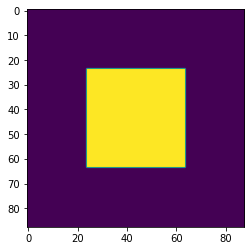

2022-04-05 13:37:47.789554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 13:37:48.527740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6128 MB memory:  -> device: 0, name: GeForce RTX 3070, pci bus id: 0000:a1:00.0, compute capability: 8.6
2022-04-05 13:37:48.528551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6038 MB memory:  -> device: 1, name: GeForce RTX 3070, pci bus id: 0000:c1:00.0, compute capability: 8.6
2022-04-05 13:37:49.163383: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. 

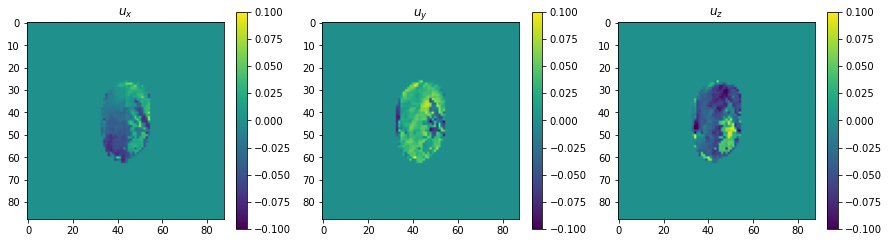

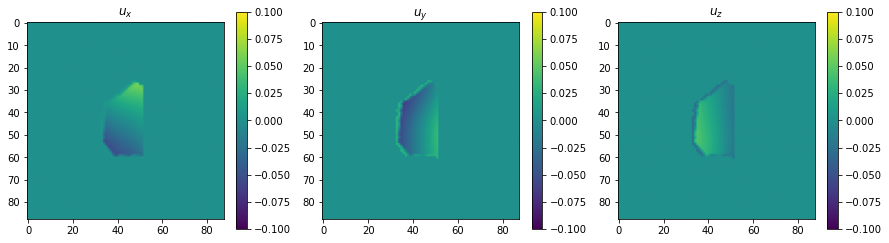

In [6]:
shp = data[0].shape
supp = np.zeros(shp)
supp[shp[0]//2-20:shp[0]//2+20,shp[0]//2-20:shp[0]//2+20,shp[0]//2-20:shp[0]//2+20] = 1

plt.imshow(supp[:,:,shp[2]//2])
plt.show()



Phaser = cpr(data,qs,supp,0.3579,random_start=True)
Phaser.run_recipes(recipes)
vals = Phaser.extract_vals()
uu,amp,supp = unpack_obj(vals)

plot_u(uu,(-0.1,0.1))
plot_u(center_u(u,sup==1),(-0.1,0.1))

## Multi-Phaser GA ##
The GA works exactly the same way. You will need to specify the number of generations, the number of individuals, the recipe for each generation, and the factor by which you would like to cull the population after each generation

##########################################################################################
Generation: 0
Individual: 0
Time to Reconstruct: 5.74 seconds
L: 4.252857e-05 
Chi: 873409.75 

Individual: 1
Time to Reconstruct: 5.75 seconds
L: 5.2058604e-05 
Chi: 1114572.8 

Individual: 2
Time to Reconstruct: 5.8 seconds
L: 2.2723341e-05 
Chi: 784186.25 

Individual: 3
Time to Reconstruct: 5.82 seconds
L: 5.458568e-06 
Chi: 964239.5 

Individual 2 Wins


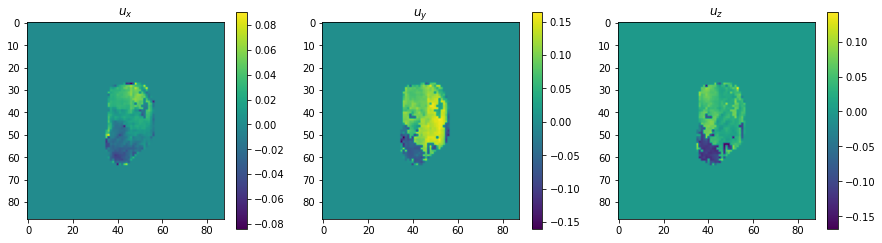

##########################################################################################
Generation: 1
Individual: 0
Time to Reconstruct: 5.32 seconds
L: 2.0039464e-05 
Chi: 540435.6 

Individual: 1
Time to Reconstruct: 5.26 seconds
L: 3.4704103e-06 
Chi: 611843.5 

Individual: 2
Time to Reconstruct: 5.17 seconds
L: 1.699341e-05 
Chi: 587292.06 

Individual: 3
Time to Reconstruct: 5.26 seconds
L: 4.2270976e-06 
Chi: 619710.5 

Individual 0 Wins


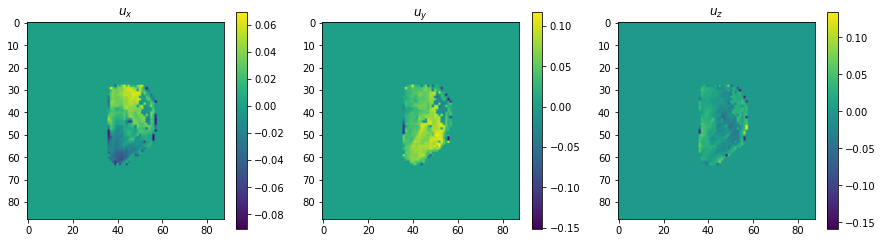

##########################################################################################
Generation: 2
Individual: 0
Time to Reconstruct: 5.27 seconds
L: 1.7566588e-05 
Chi: 506160.06 

Individual: 1
Time to Reconstruct: 5.21 seconds
L: 6.9646026e-06 
Chi: 419427.38 

Individual: 2
Time to Reconstruct: 5.19 seconds
L: 1.2691464e-05 
Chi: 453770.88 

Individual: 3
Time to Reconstruct: 5.2 seconds
L: 9.602115e-06 
Chi: 460937.28 

Individual 1 Wins


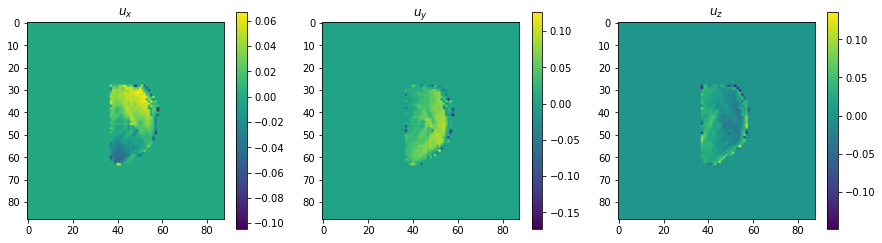

##########################################################################################
Generation: 3
Individual: 0
Time to Reconstruct: 5.21 seconds
L: 7.3017886e-06 
Chi: 404540.75 

Individual: 1
Time to Reconstruct: 5.15 seconds
L: 7.14828e-06 
Chi: 345141.84 

Individual 1 Wins


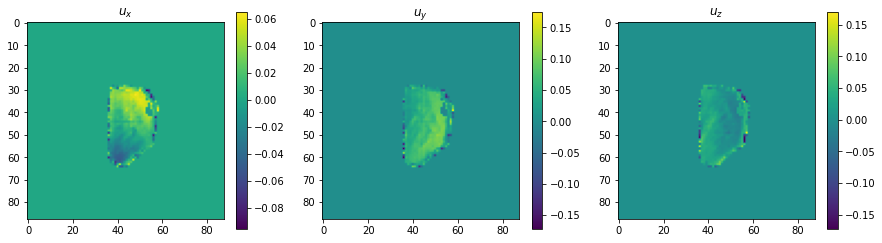

##########################################################################################
Generation: 4
Individual: 0
Time to Reconstruct: 5.28 seconds
L: 6.0258903e-06 
Chi: 349644.25 

Individual: 1
Time to Reconstruct: 5.23 seconds
L: 7.070525e-06 
Chi: 342507.62 

Individual 1 Wins


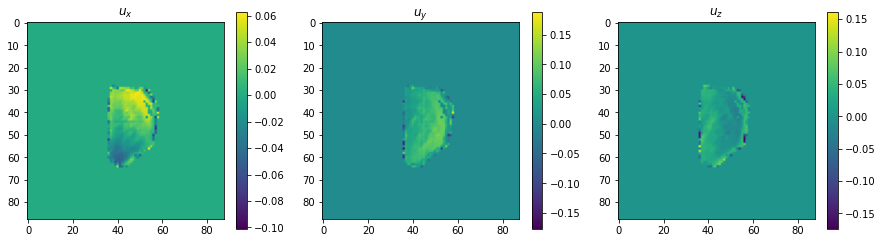

##########################################################################################
Generation: 5
Individual: 0
Time to Reconstruct: 5.16 seconds
L: 6.6180332e-06 
Chi: 328884.53 

Individual: 1
Time to Reconstruct: 5.14 seconds
L: 6.587463e-06 
Chi: 336980.97 

Individual 0 Wins


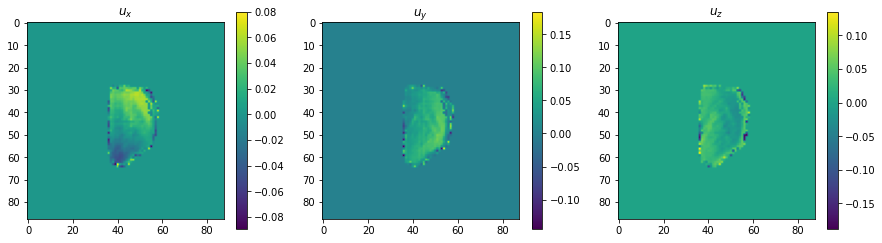

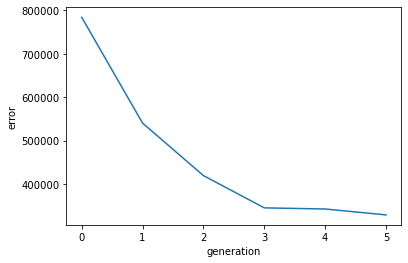

328884.53


In [7]:
from coupled_phaser_GA import run_ga

num_gen = 6
num_ind = 4
Recipes = [recipes for i in range(num_gen)]
cull = [1,1,1,2,1,1]




vals = run_ga(data,qs,supp,a,Recipes,num_gen,num_ind,cull,criterion='chi',verbose=True)
# plot_u(vals['u'],(-0.1,0.1))
plt.plot(vals['chi'])
plt.xlabel('generation')
plt.ylabel('error')
plt.show()
print(vals['chi'][-1])